# Assignment 2 - Data from the web

## Data scraping

## 1. Obtain all the data

In [2]:
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import math
import os
import os.path
import re
import matplotlib.pyplot as plt
from IPython.display import display
from bs4 import BeautifulSoup
from scipy import stats

The first thing to do is to get the base URL (basically looking at the address bar of the browser).
We need a second variable INDEX_PARAM because this page is using frames, and we'll need the base address to access them.

In [3]:
BASE_URL = "http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm"
INDEX_PARAM = "ww_i_reportmodel=133685247"

Then let's fetch the parameters names, but as it is a bit tricker, BeautifulSoup will be a great help for this (and also some manual html inspection).

In [4]:
r = requests.get(BASE_URL + '?' + INDEX_PARAM)
soup = BeautifulSoup(r.text, 'html.parser')


#print(soup)

for frame in soup.find_all('frame'):
    if frame['name'] == 'toc':
        r = requests.get("http://isa.epfl.ch/imoniteur_ISAP/" + frame['src'])
        print(frame['src'])
# The content of the frame

# Print slects
soup = BeautifulSoup(r.text, 'html.parser')
query = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247'
    


!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247


For convenience, we also create another function that builds the query from some desired parameters.

In [5]:
def build_query(section, startYear, endYear, semesterType, semesterNumber, semesterSeason):
    # Print slects
    soup = BeautifulSoup(r.text, 'html.parser')
    query = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247'


    for in_put in soup.findAll('input'):
        #print (in_put['name'])
        if in_put.text == "xls":
        #print(in_put['value'])
            query = query + '&' + in_put['name'] + '=' + in_put['value']
     
    for select in soup.findAll('select'):
    #print (select['name'])
        for t in select.findAll('option'):
        #print(t)
            if t.text == section:
            #print(t['value'])
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == str(startYear) + '-' + str(endYear):
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == semesterType + " " + str(semesterNumber):
                query = query + '&' + select['name'] + '=' + t['value']
            if t.text == "Semestre " + semesterSeason:
                query = query + '&' + select['name'] + '=' + t['value']
    return query


And finally a nice function to easily query the EPFL page and get the data from it.

In [6]:
DATA_FOLDER_PATH = 'Data/'
os.makedirs(DATA_FOLDER_PATH, exist_ok=True) #creates folder it it doesn't exist
COLUMNS_NAMES = ["civility", "name", "bachelor_orientation", "master_orientation", "specialisation", "optional_spec", "minor", "status", "exchange_type", "exchange_school", "sciper"]
def query_epfl(section, startYear, endYear, semesterType, semesterNumber, semesterSeason, update = False, writeToFile = True):
    #we create files to save the queries (and network bandwidth)
    path = str(section) + str(startYear) + str(endYear) + str(semesterType) + str(semesterNumber) + str(semesterSeason)
    
    #to avoid file naming issues
    path = re.sub('[^A-Za-z0-9]+', '', path)
    path += ".xls"
    
    df = None
    #we query the epfl server only if the file does not exist, or if we want to update the data
    if(not os.path.isfile(DATA_FOLDER_PATH + path) or update):
        queryString = build_query(section, startYear, endYear, semesterType, semesterNumber, semesterSeason)
        response = requests.get(queryString, stream=True)
        if response.status_code == 200:
            data = pd.read_html(response.text, match='.+', flavor=None, header=1, index_col=None, skiprows=1)
            df = data[0]
            df.drop(df.columns[[11, 12]], axis=1, inplace=True) #remove useless columns (all are empty)
            df.columns = COLUMNS_NAMES
            
            #cleaning the invalid rows (basically mapping the scipers to real numbers and remove the non-number rows)
            scipers = df['sciper']
            df = df.drop('sciper', axis=1)
            df = df.join(scipers.apply(pd.to_numeric, errors='coerce'))
            df = df[~df.sciper.isnull()]
            
            if writeToFile:
                df.to_excel(DATA_FOLDER_PATH + path) #save to xls file
    else:
        df = pd.read_excel(DATA_FOLDER_PATH + path, sheetname=0, header=0)
    
    return df

We can now start using those functions to collect data. 
Example below:

In [7]:
test = query_epfl("Informatique", 2007,2008, "Bachelor semestre", 3, "d'automne")
test.head()

,civility,name,bachelor_orientation,master_orientation,specialisation,optional_spec,minor,status,exchange_type,exchange_school,sciper
0,Monsieur,Aapro Niccolò,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,170617
1,Monsieur,Arn Patrick,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,174454
2,Monsieur,Balas Martin,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,174774
3,Monsieur,Bandelier Matthieu,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,173962
4,Monsieur,Bindschaedler Laurent,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,170654


## 2. Bachelor

We're now going to collect and merge every single semester of every single year. We'll append columns "year", "semester".

Together with a student's sciper, we'll use this to make unique indexes. We could've used the name but it's possible that two students with the same name would be in the same class in the same year and semestre.

In [8]:
frames = []
for year in range(2007, 2017):
    for semester in range (1, 7):
        if(semester % 2 == 0 ):
            season="de printemps"
        else:
            season="d'automne"
            
        df = query_epfl("Informatique", year,year+1, "Bachelor semestre", semester, season)
        df['year'] = year
        df['semester'] = semester
        #we use semester as first index for simplicity of use in next part
        df.set_index(['semester', 'year', 'sciper'], drop=False, append=False, inplace=True)
        if (not df.index.is_unique):
            print("Error: non unique index in year:" + str(year) + "-" + str(year+1) + ", semester:" + str(semester) + ", season:" + str(season))
            
        frames.append(df)

bStudents = pd.concat(frames)
bStudents.shape

(5808, 13)

We make sure the index is unique

In [9]:
bStudents.index.is_unique

True

For better readability, we now drop all columns that are completely empty

In [10]:
bStudents = bStudents.dropna(axis=1, how='all')

In [11]:
bStudents.head()

civility                name optional_spec   status  \
semester year sciper                                                        
1        2007 169569  Monsieur   Arévalo Christian           NaN  Présent   
              174905  Monsieur     Aubelle Flavien           NaN  Présent   
              173922  Monsieur       Badoud Morgan           NaN  Présent   
              179406  Monsieur  Baeriswyl Jonathan           NaN  Présent   
              179428  Monsieur     Barroco Michael           NaN  Présent   

                     exchange_type exchange_school  sciper  year  semester  
semester year sciper                                                        
1        2007 169569           NaN             NaN  169569  2007         1  
              174905           NaN             NaN  174905  2007         1  
              173922           NaN             NaN  173922  2007         1  
              179406           NaN             NaN  179406  2007         1  
              179428           NaN             NaN  179428  2007         1

With this very nice table, we still need the keep the students present in semester 1 and semester 6 only (and also filter out the columns we don't need).

In [12]:
bStudentsS1toS6 = pd.merge(bStudents.loc[1], bStudents.loc[6], how='inner', on=['civility', 'name', 'sciper'], suffixes=('_S1', '_S6'))
bStudentsS1toS6 = bStudentsS1toS6[['civility', 'sciper', 'year_S1', 'year_S6']] #only retain the important fields

bStudentsS1toS6['year_S6'] += 1 #we do this because the last year is not the graduation year, but when it started (2015-2016 = 2015)
bStudentsS1toS6['ydiff'] = bStudentsS1toS6['year_S6'] - bStudentsS1toS6['year_S1']

bStudentsS1toS6 = bStudentsS1toS6.groupby('sciper', group_keys=False).apply(lambda x: x.ix[x.ydiff.idxmax()])
bStudentsS1toS6.set_index('sciper', inplace=True)
bStudentsS1toS6.head()

,civility,year_S1,year_S6,ydiff
sciper,,,,
147008,Monsieur,2008,2011,3
169569,Monsieur,2007,2010,3
169731,Monsieur,2007,2011,4
169795,Monsieur,2007,2011,4
171195,Monsieur,2007,2010,3


Quick check before proceeding

In [13]:
bStudentsS1toS6.index.is_unique

True

Before going further, we will modify the dataframe a bit to simplify the processing of genders

In [14]:
gender_map = {"Monsieur": 0, "Madame": 1}
#bStudentsS1toS6['civility'] = bStudentsS1toS6['civility'].map(gender_map)

As a first approach, we use the 'describe' methods of pandas on the ydiff field

In [15]:
bStudentsS1toS6['ydiff'].describe()

count    397.000000
mean       3.468514
std        0.733155
min        3.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        7.000000
Name: ydiff, dtype: float64

Ignoring the count (which is meaningless in this case) and the min (since you can't get the bachelor in less than 3 years), we observe quite a low mean and std, but these should not be over considered since they are weak against outliers. 
But the quantiles give us nice informations, more than 50% of students graduated in 3 years (which is the minimum) and 75% in 4 years!
Then the maximum is 7, that is uncommon since you have 6 years to graduate.
Let's find out how many people are in this case

In [16]:
bStudentsS1toS6[bStudentsS1toS6.ydiff == 7]

,civility,year_S1,year_S6,ydiff
sciper,,,,
196034,Monsieur,2009,2016,7


As only one person is concerned, we can then assume that this dude had some special treatment.

Now that we are certain that our dataset is well formed, we can start to analyze it properly.
We begin by grouping the students by their graduation time.

ydiff
3    259
4     98
5     33
6      6
7      1
dtype: int64

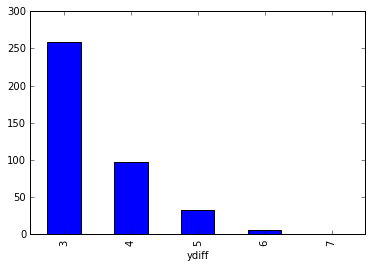

In [17]:
bStudentsS1toS6_grp = bStudentsS1toS6.groupby(bStudentsS1toS6.ydiff)
bStudentsS1toS6_grp.size().plot.bar()
bStudentsS1toS6_grp.size()

We don't see many more things than what the 'described()' function showed, only the large amount of people having graduated in the minimal time.

The next step is to split the students by their gender.

In [18]:
bStudentsByGender = bStudentsS1toS6.groupby(bStudentsS1toS6.civility)
bStudentsByGender.describe()

ydiff      year_S1      year_S6
civility                                            
Madame   count   29.000000    29.000000    29.000000
         mean     3.310345  2010.620690  2013.931034
         std      0.541390     2.060059     2.170106
         min      3.000000  2007.000000  2010.000000
         25%      3.000000  2009.000000  2012.000000
         50%      3.000000  2011.000000  2014.000000
         75%      4.000000  2012.000000  2016.000000
         max      5.000000  2014.000000  2017.000000
Monsieur count  368.000000   368.000000   368.000000
         mean     3.480978  2010.475543  2013.956522
         std      0.745316     2.029604     2.017164
         min      3.000000  2007.000000  2010.000000
         25%      3.000000  2009.000000  2012.750000
         50%      3.000000  2011.000000  2014.000000
         75%      4.000000  2012.000000  2016.000000
         max      7.000000  2014.000000  2017.000000

Nothing significant to report here, only that most of the graduated students are men (368 against 29).

Mean:
civility
Madame      3.310345
Monsieur    3.480978
Name: ydiff, dtype: float64
STD:
civility
Madame      0.541390
Monsieur    0.745316
Name: ydiff, dtype: float64


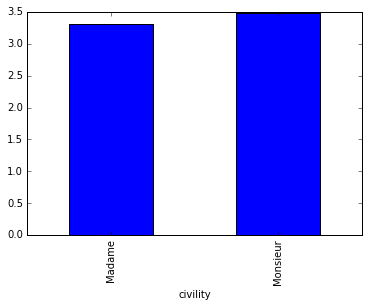

In [19]:
bStudentsByGender['ydiff'].mean().plot.bar()
print("Mean:\n" + str(bStudentsByGender['ydiff'].mean()))
print("STD:\n" + str(bStudentsByGender['ydiff'].std()))

Using a boxplot, we can barely see any difference. Except for an outlier in the male category

OrderedDict([('Madame',
              <matplotlib.axes._subplots.AxesSubplot at 0x24d2fa3f240>),
             ('Monsieur',
              <matplotlib.axes._subplots.AxesSubplot at 0x24d2fa8ce80>)])

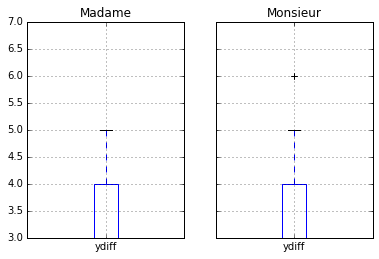

In [20]:
bStudentsByGender.boxplot(column ='ydiff', return_type='axes' )

The best test to determine whether the difference in distribution is actually different or not is the Wilcoxon-Mann-Whitney u test. For two reasons :
- This isn't a normal distribution (peak will be at 3, but you can't go left, only right)
- We aren't comparing paired samples

We will use it now with the two tailed test because we're looking for significant differences in any direction

In [102]:
subset_male = bStudentsS1toS6[bStudentsS1toS6['civility'] == 'Monsieur'  ]
subset_female = bStudentsS1toS6[bStudentsS1toS6['civility'] == 'Madame'  ]

stats.mannwhitneyu(subset_male.ydiff, subset_female.ydiff, alternative = 'two-sided').pvalue

0.31072323298070637

As we can see we are far from a significant p-value.

So we can conclude that there is no significant difference here, only that female students are a bit better and more uniformly distributed, but the size of the sample is too low to establish conclusions.

## 3. Master


Now let's try to do the same thing for the Master students. We will use the same query fuction 

In [22]:
frames = []
for year in range(2007, 2017):
    for semester in range (1, 4):
        if(semester % 2 == 0 ):
            season="de printemps"
        else:
            season="d'automne"
            
        df = query_epfl("Informatique", year,year+1, "Master semestre", semester, season)
        df['year'] = year
        df['semester'] = semester
        #we use semester as first index for simplicity of use in next part
        df.set_index(['semester', 'year', 'sciper'], drop=False, append=False, inplace=True)
        if (not df.index.is_unique):
            print("Error: non unique index in year:" + str(year) + "-" + str(year+1) + ", semester:" + str(semester) + ", season:" + str(season))
            
        frames.append(df)

msStudents = pd.concat(frames)
msStudents.shape

(2716, 13)

And again just a quick check

In [23]:
msStudents.index.is_unique

True

In [24]:
msStudents.head()

civility                       name  \
semester year sciper                                        
1        2007 153066  Monsieur  Aeberhard François-Xavier   
              180027    Madame              Agarwal Megha   
              152232  Monsieur         Anagnostaras David   
              177395  Monsieur              Auroux Damien   
              161970  Monsieur             Awalebo Joseph   

                      bachelor_orientation  master_orientation specialisation  \
semester year sciper                                                            
1        2007 153066                   NaN                 NaN            NaN   
              180027                   NaN                 NaN            NaN   
              152232                   NaN                 NaN            NaN   
              177395                   NaN                 NaN            NaN   
              161970                   NaN                 NaN            NaN   

                      optional_spec minor   status exchange_type  \
semester year sciper                                               
1        2007 153066            NaN   NaN  Présent           NaN   
              180027            NaN   NaN  Présent           NaN   
              152232            NaN   NaN  Présent           NaN   
              177395            NaN   NaN  Présent           NaN   
              161970            NaN   NaN  Présent           NaN   

                     exchange_school  sciper  year  semester  
semester year sciper                                          
1        2007 153066             NaN  153066  2007         1  
              180027             NaN  180027  2007         1  
              152232             NaN  152232  2007         1  
              177395             NaN  177395  2007         1  
              161970             NaN  161970  2007         1

In [25]:
msStudentsS1toS2 = pd.merge(msStudents.loc[1], msStudents.loc[2], how='inner', on=['civility', 'name', 'sciper'], suffixes=('_S1', '_S2'))
msStudentsS1toS2 = msStudentsS1toS2[['civility', 'sciper', 'minor_S2' , 'specialisation_S2','year_S1', 'year_S2']] #only retain the important fields
# We only get the minor and spec. info form the second semester because it is the most recent data and the time when most people make the slection

#Here we will make an assumption that all people that are in semester 2 and have not selected an minor or spec, 
#decided to take the 90 ECTS master and a probaly doing a master project
msStudentsS1toS2 = msStudentsS1toS2[pd.isnull(msStudentsS1toS2['minor_S2']) & pd.isnull(msStudentsS1toS2['specialisation_S2'])]

#We will calculate the study time in months 
msStudentsS1toS2['year_S2'] += 1 #again, we do this because a spring semester in (2015-2016) will count as 2015 but the actual year is 2016
msStudentsS1toS2['months'] = (msStudentsS1toS2['year_S2'] - msStudentsS1toS2['year_S1']) * 12 + 6

msStudentsS1toS2= msStudentsS1toS2.groupby('sciper', group_keys=False).apply(lambda x: x.ix[x.months.idxmax()])
msStudentsS1toS2.set_index('sciper', inplace=True)

In [26]:
msStudentsS1toS2.head()

,civility,minor_S2,specialisation_S2,year_S1,year_S2,months
sciper,,,,,,
146330,Monsieur,NaN,NaN,2007,2008,18
146929,Monsieur,NaN,NaN,2007,2008,18
147008,Monsieur,NaN,NaN,2011,2013,30
153066,Monsieur,NaN,NaN,2007,2009,30
153746,Monsieur,NaN,NaN,2007,2008,18


In [27]:
msStudentsS1toS2.groupby('months').count().civility

months
6      23
18    404
30     85
42      4
Name: civility, dtype: int64

In [28]:
msStudentsS1toS2.months.mean()

19.627906976744185

From here we can see that the average time it takes to complete a masters at epfl with out a specilization or minor is aorund 19.6 months. Most people finish in 18 months which is the required minimum.
There are some people that appear to have started the studies directly in their second semester and we assume that they are people with special treatment.

Now let's take a look at the people with a minor or specilization

In [29]:
msStudentsS1toS2Spec = pd.merge(msStudents.loc[1], msStudents.loc[2], how='inner', on=['civility', 'name', 'sciper'], suffixes=('_S1', '_S2'))
msStudentsS1toS2Spec = msStudentsS1toS2Spec[['civility', 'sciper', 'minor_S2' , 'specialisation_S2','year_S1', 'year_S2']] 

We will use the data we aleady have but this time we will also check if the sudent has finished Semester 3

In [30]:
msStudentsS1toS2Spec = msStudentsS1toS2Spec[pd.notnull(msStudentsS1toS2Spec['minor_S2']) | pd.notnull(msStudentsS1toS2Spec['specialisation_S2'])]
#We will calculate the study time in months 
msStudentsS1toS2Spec['year_S2'] += 1 #again, we do this because a spring semester in (2015-2016) will count as 2015 but the actual year is 2016
msStudentsS1toS2Spec['months'] = (msStudentsS1toS2Spec['year_S2'] - msStudentsS1toS2Spec['year_S1']) * 12 + 6
                                                                                                      

msStudentsS1toS2Spec= msStudentsS1toS2Spec.groupby('sciper', group_keys=False).apply(lambda x: x.ix[x.months.idxmax()])
msStudentsS1toS2Spec.set_index('sciper', inplace=True)

Now we will get the people that have done Semester 3 and we will elimintae students which have a Minor or Specilization and do not have a Master Semester 3

In [31]:
msStudentsS3 = msStudents.loc[3]
msStudentsS3.set_index('sciper', inplace=True)
indexes = msStudentsS1toS2Spec.index.intersection(msStudentsS3.index.unique())
msStudentsS1toS2Spec = msStudentsS1toS2Spec.loc[indexes]
#Here we also need to do one more correction Since we have the time difference between S2 and S1 The people that do S1, S2 and S3 
#And then finish will appear as only 18-months we need to correct this because this is infact 24 since we already checked if they did S3
msStudentsS1toS2Spec.loc[msStudentsS1toS2Spec['months'] == 18, 'months'] = 24

Now we can calucalte the average time it takes to finish with a Minor or Specilization

In [32]:
msStudentsS1toS2Spec.months.mean() 

27.47252747252747

We can now calucalte and overall averrage of all Masters 

In [33]:
(msStudentsS1toS2Spec.months.mean() * len(msStudentsS1toS2Spec) + msStudentsS1toS2.months.mean() 
 * len(msStudentsS1toS2)) / (len(msStudentsS1toS2Spec)+len(msStudentsS1toS2))

22.342205323193916

So on average a student at EPFL will finish their Master in about  22 months

Let's break down the averages by Specilizations

In [34]:
msStudentsS1toS2Spec = msStudentsS1toS2Spec[pd.notnull(msStudentsS1toS2Spec['specialisation_S2'])]

In [35]:
msStudentsS1toS2Spec.groupby('specialisation_S2').months.mean()

specialisation_S2
Biocomputing                      30.000000
Computer Engineering - SP         27.000000
Computer Science Theory           24.000000
Data Analytics                    24.000000
Foundations of Software           28.333333
Information Security - SP         25.714286
Internet Information Systems      24.000000
Internet computing                27.662338
Service science                   27.000000
Signals, Images and Interfaces    28.857143
Software Systems                  25.500000
Name: months, dtype: float64

I will use only the average of the students with Sepcilizations to compare it with average stay per each category. For this task we will use the One-Sample T-Test but first let's do a simple describe

In [36]:
  pd.set_option('display.max_rows', 1000) #Just to force Pandas to print all the rows and not to print ... 
msStudentsS1toS2Spec.groupby('specialisation_S2').months.describe()

specialisation_S2                    
Biocomputing                    count     2.000000
                                mean     30.000000
                                std       0.000000
                                min      30.000000
                                25%      30.000000
                                50%      30.000000
                                75%      30.000000
                                max      30.000000
Computer Engineering - SP       count    16.000000
                                mean     27.000000
                                std       3.098387
                                min      24.000000
                                25%      24.000000
                                50%      27.000000
                                75%      30.000000
                                max      30.000000
Computer Science Theory         count     1.000000
                                mean     24.000000
                                std         

For the describe output we can see that for some specilizations we have very small samples so it makes no sense to use a T test

In [37]:
print(stats.ttest_1samp(a= msStudentsS1toS2Spec.loc[msStudentsS1toS2Spec['specialisation_S2'] == 'Computer Engineering - SP', 'months'],    popmean= msStudentsS1toS2Spec.months.mean()))
print(stats.ttest_1samp(a= msStudentsS1toS2Spec.loc[msStudentsS1toS2Spec['specialisation_S2'] == 'Foundations of Software', 'months'],    popmean= msStudentsS1toS2Spec.months.mean()))
print(stats.ttest_1samp(a= msStudentsS1toS2Spec.loc[msStudentsS1toS2Spec['specialisation_S2'] == 'Internet computing', 'months'],    popmean= msStudentsS1toS2Spec.months.mean()))
print(stats.ttest_1samp(a= msStudentsS1toS2Spec.loc[msStudentsS1toS2Spec['specialisation_S2'] == 'Signals, Images and Interfaces', 'months'],    popmean= msStudentsS1toS2Spec.months.mean()))
print(stats.ttest_1samp(a= msStudentsS1toS2Spec.loc[msStudentsS1toS2Spec['specialisation_S2'] == 'Software Systems', 'months'],    popmean= msStudentsS1toS2Spec.months.mean()))

Ttest_1sampResult(statistic=-0.77459666924148518, pvalue=0.45061617484036998)
Ttest_1sampResult(statistic=1.2176923119055889, pvalue=0.22873459954809389)
Ttest_1sampResult(statistic=0.12218594249202235, pvalue=0.90307427274415886)
Ttest_1sampResult(statistic=1.0999999999999992, pvalue=0.28439662758989281)
Ttest_1sampResult(statistic=-3.1304951684997078, pvalue=0.0068751634124808612)


We can conclude that only in the last test the p value is below the threshold chosen for statistical significance of 0.05, but since the sample is so small there isn't much to conclude from this.

## 4. BONUS PART

We will look at the evolution of time spent in a master's degree for men and women.
First we beging with men :

The whiter a point is, the denser it is

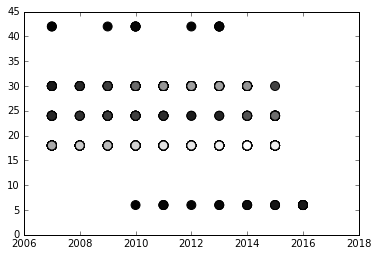

In [81]:
msStudentsTotal = msStudentsS1toS2.append(msStudentsS1toS2Spec) #merge the students with and without specs

subset_male = msStudentsTotal[msStudentsTotal['civility'] == 'Monsieur'  ]
subset_female = msStudentsTotal[msStudentsTotal['civility'] == 'Madame'  ]

xy = np.vstack([subset_male.year_S1,subset_male.months]) #used to get density per point, inspired by http://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
z = stats.gaussian_kde(xy)(xy)

plt.scatter(x=subset_male.year_S1, y=subset_male.months, c = z, s=80);


And now for women

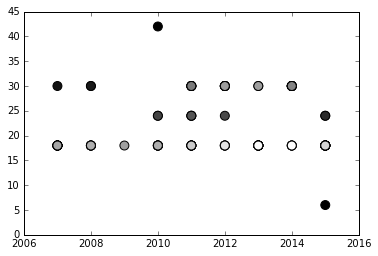

In [82]:
xy = np.vstack([subset_female.year_S1,subset_female.months]) #used to get density per point, inspired by http://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
z = stats.gaussian_kde(xy)(xy)

plt.scatter(x=subset_female.year_S1, y=subset_female.months, c=z, s=80);

As we can see the most dense points are in the middle for both groups, men have more outliers but their sample is also much bigger, so this is to be expected and not every statistically relevant


We will now ask pandas to describe the stats in months spent in a master's degree per gender, and plot the results that go with it

In [84]:
msStudentsByGender = msStudentsTotal.groupby(msStudentsTotal.civility)
msStudentsByGender.months.describe()

civility       
Madame    count     92.000000
          mean      21.782609
          std        5.881291
          min        6.000000
          25%       18.000000
          50%       18.000000
          75%       30.000000
          max       42.000000
Monsieur  count    624.000000
          mean      21.865385
          std        6.481569
          min        6.000000
          25%       18.000000
          50%       18.000000
          75%       30.000000
          max       42.000000
Name: months, dtype: float64

Mean:
civility
Madame      21.782609
Monsieur    21.865385
Name: months, dtype: float64
STD:
civility
Madame      5.881291
Monsieur    6.481569
Name: months, dtype: float64


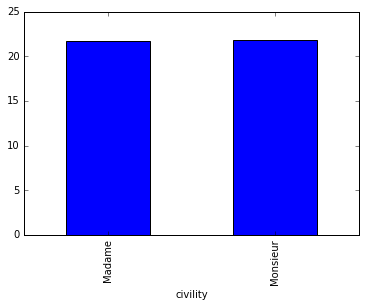

In [85]:
msStudentsByGender['months'].mean().plot.bar()
print("Mean:\n" + str(msStudentsByGender['months'].mean()))
print("STD:\n" + str(msStudentsByGender['months'].std()))

OrderedDict([('Madame',
              <matplotlib.axes._subplots.AxesSubplot at 0x24d2e048dd8>),
             ('Monsieur',
              <matplotlib.axes._subplots.AxesSubplot at 0x24d313f8470>)])

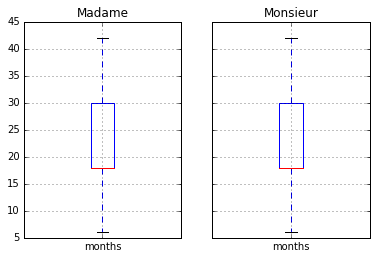

In [87]:
msStudentsByGender.boxplot(column ='months', return_type='axes' )

As we can clearly see on those graphs, the distributions are extremely close, almost similar. This leads us to believe that the gender of a person has no effect on their stay duration in a master's degree.

We can verify this by using the Wilcoxon-Mann-Whitney u test once again, since those are non normally distributed and independent samples

We check the null hypothesis "A person's gender has an effect on the time spent on a master's degree"

In [101]:
stats.mannwhitneyu(subset_male.months, subset_female.months, alternative = 'two-sided').pvalue

0.70839055247428218

The p value is extremely far from relevant, contradicting the null hypothesis